# Scaled and Shifted Free-Space Propagation

In common free-space propagation methods (Fraunhofer, Fresnel, angular spectrum), we do not have control on the output plane sampling: the resolution, the sampling interval, the region-of-interest. In some cases, we may want to control the output plane sampling, e.g. to match the sampling of a detector.

In this notebook, we compare different approaches for doing rescaled free-space progation with the Fresnel approximation and the angular spectrum method (no approximation). We show how to specify different sampling parameters at the input and output planes. 

Bandlimited angular spectrum (BLAS) is generally prefered as it can be used for both near-field and far-field propagation. We compare the following approaches for scaled BLAS propagation:

1. ["Band-limited angular spectrum numerical propagation method with selective scaling of observation window size and sample number"](https://opg.optica.org/josaa/viewmedia.cfm?uri=josaa-29-11-2415&html=true) (Yu et al., 2012) 
2. Using the chirp Z-transform (CZT) to resample the angular spectrum, similar to ["Efficient full-path optical calculation of scalar and vector diffraction using the Bluestein method"](https://www.nature.com/articles/s41377-020-00362-z) (Hu et al., 2020)

Let's first define the setup, with all units in microns, and create a rectangular aperture as input.

Field shape [um]:  1089.536
Width of aperture [um]:  108.95360000000001
Propagation distance [um]:  10895.36


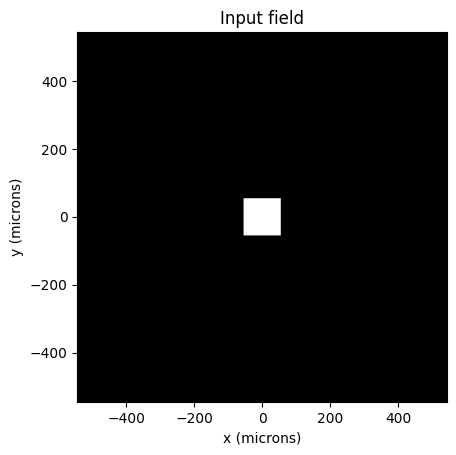

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

import chromatix.functional as cf
from chromatix.utils import plot_field

# import jax
# jax.config.update("jax_enable_x64", True)

shape = (1024, 1024)  # [px, px]
N_pad = (shape[0] // 2, shape[1] // 2)  # [px, px] padding to linearize the FFT
spectrum = 0.532  # wavelength [um]
dxi = 2 * spectrum
D = dxi * shape[0]  # field shape
w = D / 10  # width of aperture
z = 10 * D  # propagation distance
dxi = D / np.array(shape)
spacing = dxi[..., np.newaxis]
n = 1  # refractive index of medium

print("Field shape [um]: ", D)
print("Width of aperture [um]: ", w)
print("Propagation distance [um]: ", z)

field = cf.plane_wave(
    shape=shape,
    dx=spacing,
    spectrum=spectrum,
    spectral_density=1.0,
    pupil=partial(cf.square_pupil, w=w),
)
ax = plot_field(field)
ax.set_title("Input field")
ax.set_ylabel("y (microns)")
ax.set_xlabel("x (microns)");

Let's propagate with bandlimited angular spectrum (no scaling for now).

Computation time: 1.01 s
Output field dtype:  float32
Output field shape:  (1024, 1024)


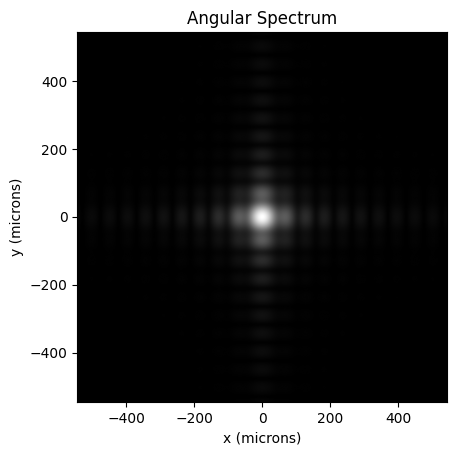

In [2]:
import time

# Angular spectrum (bandlimited)
start_time = time.time()
out_field_blas = cf.asm_propagate(field, z, n, N_pad=N_pad, mode="same", bandlimit=True)
print(f"Computation time: {time.time() - start_time:.2f} s")
print("Output field dtype: ", out_field_blas.amplitude.dtype)
print("Output field shape: ", out_field_blas.spatial_shape)

ax = plot_field(out_field_blas)
ax.set_title("Angular Spectrum")
ax.set_ylabel("y (microns)")
ax.set_xlabel("x (microns)");

Let's zoom into to a specific region of interest.

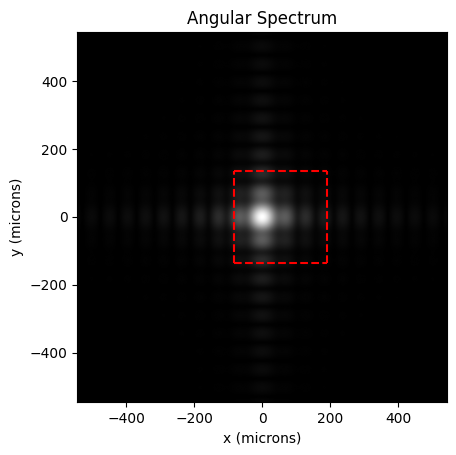

In [3]:
from chromatix.utils import bounding_box

zoom_factor = 4
shift_yx = [0, w / 2]

ax = plot_field(out_field_blas)
ax.set_title("Angular Spectrum")
ax.set_ylabel("y (microns)")
ax.set_xlabel("x (microns)")

# Draw bounding box
y_bounds, x_bounds = field.spatial_limits
x_bounds = [
    x_bounds[0] / zoom_factor + shift_yx[1],
    x_bounds[1] / zoom_factor + shift_yx[1],
]
y_bounds = [
    y_bounds[0] / zoom_factor + shift_yx[0],
    y_bounds[1] / zoom_factor + shift_yx[0],
]
bounding_box(
    ax=ax,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    c="r",
    linestyle="--",
    surface_area=field.surface_area.squeeze(),
)

The naive approach for zooming into this region (while maintaining the same resolution) would be to increase the size of the input field. 

However, this may require large memory and computation requirements.

Input field shape :  (4096, 4096)
Computation time: 1.81 s


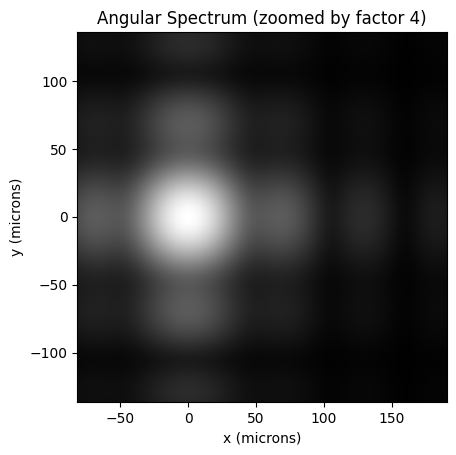

In [4]:
# for similar resolution as zoom need to increase field size
shape_hi_res = (shape[0] * zoom_factor, shape[1] * zoom_factor)
spacing_hi_res = dxi / zoom_factor
spacing_hi_res = spacing_hi_res[..., np.newaxis]
N_pad_hi_res = (shape_hi_res[0] // 2, shape_hi_res[1] // 2)

field_hi_res = cf.plane_wave(
    shape=shape_hi_res,
    dx=spacing_hi_res,
    spectrum=spectrum,
    spectral_density=1.0,
    pupil=partial(cf.square_pupil, w=w),
)
print("Input field shape : ", field_hi_res.spatial_shape)

# Angular spectrum (bandlimited)
start_time = time.time()
out_field_blas_hires = cf.asm_propagate(
    field_hi_res, z, n, N_pad=N_pad_hi_res, mode="same", bandlimit=True
)
print(f"Computation time: {time.time() - start_time:.2f} s")

# plot
ax = plot_field(out_field_blas_hires)
ax.set_title(f"Angular Spectrum (zoomed by factor {zoom_factor})")
ax.set_ylabel("y (microns)")
ax.set_xlabel("x (microns)")
ax.set_xlim(x_bounds[0], x_bounds[1])
ax.set_ylim(y_bounds[0], y_bounds[1]);

That's significantly more compute time, and it would only get worse if we need to zoom in further.

### 1) "Band-limited angular spectrum numerical propagation method with selective scaling of observation window size and sample number" (Yu et al., 2012)  

Below we apply the technique suggested by [Yu et al.](https://opg.optica.org/josaa/fulltext.cfm?uri=josaa-29-11-2415&id=244612) in 2012. By default when setting the output sampling (`dx` or `N_out`), the CZT-based approach is used, which we will see is faster.

For comparison, we set `use_czt=False` to use the approach by Yu et al.

Computation time: 0.65 s
Output field shape :  (1024, 1024)
Output field norm :  3.1434326


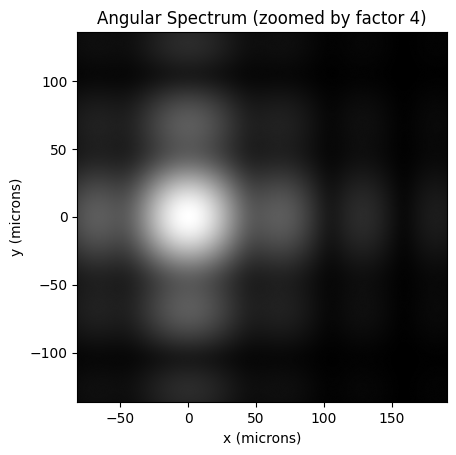

In [5]:
start_time = time.time()
out_field_blas_scaled = cf.asm_propagate(
    field,
    z,
    n,
    N_pad=N_pad,
    mode="same",
    bandlimit=True,
    # adjust spacing to zoom in
    output_dx=spacing / zoom_factor,
    shift_yx=shift_yx,
    use_czt=False,
)
print(f"Computation time: {time.time() - start_time:.2f} s")
print("Output field shape : ", out_field_blas_scaled.spatial_shape)
print("Output field norm : ", np.linalg.norm(out_field_blas_scaled.amplitude))

ax = plot_field(out_field_blas_scaled)
ax.set_title(f"Angular Spectrum (zoomed by factor {zoom_factor})")
ax.set_ylabel("y (microns)")
ax.set_xlabel("x (microns)");

### 2) Based on the Chirp Z-transform (CZT)

Below we apply a technique based on the Chirp Z-transform, similar to the one suggested by [Hu et al.](https://www.nature.com/articles/s41377-020-00362-z) in 2020.

Computation time: 1.18 s
Output field shape :  (1024, 1024)
Output field norm :  44.408714


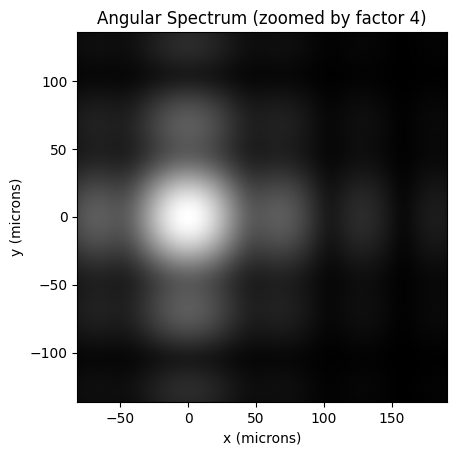

In [7]:
start_time = time.time()
out_field_blas_scaled = cf.asm_propagate(
    field,
    z,
    n,
    N_pad=N_pad,
    mode="same",
    bandlimit=True,
    # adjust spacing to zoom in
    output_dx=spacing / zoom_factor,
    shift_yx=shift_yx,
    use_czt=True,
)
print(f"Computation time: {time.time() - start_time:.2f} s")
print("Output field shape : ", out_field_blas_scaled.spatial_shape)
print("Output field norm : ", np.linalg.norm(out_field_blas_scaled.amplitude))

ax = plot_field(out_field_blas_scaled)
ax.set_title(f"Angular Spectrum (zoomed by factor {zoom_factor})")
ax.set_ylabel("y (microns)")
ax.set_xlabel("x (microns)");

We can also apply shifted and scaled free-space propagation with the **Fresnel approximation**. Note that this approximates the wavefront as parabolic (instead of spherical).

Looking closely, we can observe aliasing artifacts with Fresnel propagation when rescaling.

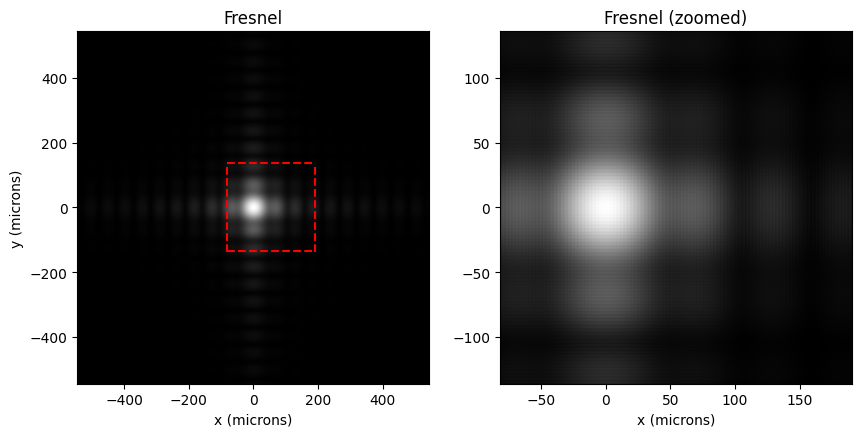

In [9]:
# original
out_field_fresnel = cf.transfer_propagate(field, z, n, N_pad=N_pad, mode="same")

# rescaled
out_field_fresnel_scaled = cf.transfer_propagate(
    field,
    z,
    n,
    N_pad=N_pad,
    mode="same",
    # adjust spacing to zoom in
    output_dx=spacing / zoom_factor,
    shift_yx=shift_yx,
)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_field(out_field_fresnel, ax=axs[0])
axs[0].set_title("Fresnel")
axs[0].set_ylabel("y (microns)")
axs[0].set_xlabel("x (microns)")
plot_field(out_field_fresnel_scaled, ax=axs[1])
axs[1].set_title("Fresnel (zoomed)")
axs[1].set_xlabel("x (microns)")
bounding_box(
    ax=axs[0],
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    c="r",
    linestyle="--",
    surface_area=field.surface_area.squeeze(),
)

### PROFILING

Below we compare the compute time.

In [14]:
n_trials = 10

# Propating larger fields
start_time = time.time()
blas_hi_res = cf.asm_propagate(
    field_hi_res, z, n, N_pad=N_pad_hi_res, mode="same", bandlimit=True
)
for _ in range(n_trials):
    cf.asm_propagate(
        field_hi_res, z, n, N_pad=N_pad_hi_res, mode="same", bandlimit=True
    )
blas_hir_res = (time.time() - start_time) / n_trials
print("-- BLAS hi-res: ", blas_hir_res)

# Yu et al. - https://opg.optica.org/josaa/fulltext.cfm?uri=josaa-29-11-2415&id=244612
start_time = time.time()
yu_et_al_result = cf.asm_propagate(
    field,
    z,
    n,
    N_pad=N_pad,
    mode="same",
    bandlimit=True,
    output_dx=spacing / zoom_factor,
    shift_yx=shift_yx,
    use_czt=False,
)
for _ in range(n_trials):
    cf.asm_propagate(
        field,
        z,
        n,
        N_pad=N_pad,
        mode="same",
        bandlimit=True,
        output_dx=spacing / zoom_factor,
        shift_yx=shift_yx,
        use_czt=False,
    )
yu_et_al = (time.time() - start_time) / n_trials
print("-- Yu et al : ", yu_et_al)

# CZT based - https://www.nature.com/articles/s41377-020-00362-z
start_time = time.time()
czt_result = cf.asm_propagate(
    field,
    z,
    n,
    N_pad=N_pad,
    mode="same",
    bandlimit=True,
    output_dx=spacing / zoom_factor,
    shift_yx=shift_yx,
    use_czt=True,
)
for _ in range(n_trials):
    cf.asm_propagate(
        field,
        z,
        n,
        N_pad=N_pad,
        mode="same",
        bandlimit=True,
        output_dx=spacing / zoom_factor,
        shift_yx=shift_yx,
        use_czt=True,
    )
czt_approach = (time.time() - start_time) / n_trials
print("-- CZT approach : ", czt_approach)

print("\nCZT speed-up (wrt hi-res BLAS)", blas_hir_res / czt_approach)
print("CZT speed-up (wrt Yu et al.)", yu_et_al / czt_approach)

-- BLAS hi-res:  2.1270426511764526
-- Yu et al :  0.4939444541931152
-- CZT approach :  0.4028259515762329

CZT speed-up (wrt hi-res BLAS) 5.280301934007645
CZT speed-up (wrt Yu et al.) 1.226198193687227


In [ ]:
# compare results
# -- element-wise comparison
np.allclose(
    yu_et_al_result.amplitude / np.linalg.norm(yu_et_al_result.amplitude),
    czt_result.amplitude / np.linalg.norm(czt_result.amplitude),
    atol=1e-4,
)
# - normalized root mean square error
h1 = yu_et_al_result.amplitude / np.linalg.norm(yu_et_al_result.amplitude)
h2 = czt_result.amplitude / np.linalg.norm(czt_result.amplitude)
np.sqrt(np.mean((h1 - h2) ** 2))

np.float32(7.4845448e-06)